## **Introduction**

In this project the forward-forward algorithm is going to be implemented for Audio and speech processing tasks. The structure of the lab is as following:


1.   Data Prepration
1.   A breif introduction to Forward-Forward (**FwFw**) Algorithm.
6. Convergence Analysis
2.   An analysis on Embedding methods for Making up positive and Negative samples in FwFw.
3. Forward- Forward on 1-d CNN on Audio Mnist. (Classification task)

4. Forward- Forward on 2-d CNN on Audio Mnist. (Classification task).  **Using spectrogram**

5. Back prop on 2-d CNN


In the following cells at first we import and download the important libs!





In [ ]:
!git clone https://github.com/soerenab/AudioMNIST /content/AudioMNIST

Cloning into '/content/AudioMNIST'...
remote: Enumerating objects: 30122, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30122 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30122/30122), 944.54 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (30018/30018), done.


In [ ]:
%%capture
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
import os
import torchaudio
from torch.utils.data import DataLoader
import random

import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa

## **Dataset Class prepration**

In this part, Audio MNIST dataset is used for our classification task. To fetch dataitems, a class is inherited from the `'Dataset'` class in `'pytorch'`, and then the `__getitem__` is getting re-writetten to fetch the audio timeserie sample.  

In [ ]:
# Audio data set prepration
%%capture
import torchaudio
from torch.utils.data import DataLoader

class Audio_MNIST_Dataset(Dataset):
    def __init__(self, path, feature_transform=None,
                 label_transform=None, train=True, train_size=0.80):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] == "wav":
                    self.file_list.append(os.path.join(dirname, filename))
                    #print(filename)
                    #print(filename.split('_')[0])

                    self.label_list.append(int((filename.split('_')[0])))

        total_len = len(self.file_list)

        if train:
            self.file_list, self.label_list = self.file_list[:int(0.80 * total_len)], self.label_list[:int(0.80 * total_len)]
        else:
            self.file_list, self.label_list = self.file_list[int(0.80 * total_len):], self.label_list[int(0.80 * total_len):]

    def __getitem__(self, idx):
        wav,sample_rate = torchaudio.load(self.file_list[idx])
        len_wav = wav.shape[1]
        wav = wav.squeeze()
        pddd = 40000

        if len_wav < pddd:
            pad = torch.zeros(pddd - len_wav)
            wav = torch.cat((wav, pad))
        elif len_wav > pddd:
            wav = wav[:pddd]
        label = self.label_list[idx]

        #print(len(label))
        #print('WAVE SHAPE', label)
        #return {'wave': self.file_list[idx], 'label':label}
        return {'wave': wav, 'label':label}

    def __len__(self):
        return len(self.file_list)



In [ ]:
# test Audio_MNIST Dataset
Dataset = Audio_MNIST_Dataset('./AudioMNIST/data')

Test_Dataset = Audio_MNIST_Dataset('./AudioMNIST/data',train = False)
Train_dataloader = DataLoader(Dataset, batch_size=100,shuffle=True)

Test_dataloader = DataLoader(Test_Dataset, batch_size=100,shuffle=True)
#print(len(dataloader))
#for batch in dataloader:
#  print(batch['wave'].shape)

#for batch in Test_dataloader:
#  print(batch['wave'].shape)

## **Introduction to Forward-Forward**

Forward-Forward initially proposed by Jeofrry Hinton as a alternative to the backpropagation algorithm in his recent [paper](https://www.cs.toronto.edu/~hinton/FFA13.pdf). The main idea rlies on instead of backpropgating error in each layer stage, it feeds forward two types of negative and positive samples in the training stage to tackle the weight adjustment in the network. It has some some differences compared to Backprop like:
1. Local loss optimization at each layer.
3. Lower dimentional parameter optimization compared to full parameter space provided by backpropagation.  

The algorithms tries to propose an alternative in a way that it could replace the backprop algorithm in the neural network. It works a follows:
* Instead of standard Backprop, the forward-forward algorithm enjoys a local loss function for each of its own, in the paper, the criteria is called *Goodness*, called $G(.)$.

* Each layer has its own threshold called $\theta$.

**An outline on Learning Process:**
1. Lets define two types of input to move froward in the network for training each layer called ***positive*** and ***negative*** samples.
2. Each layer accepts its input as  positive ($x_p$) and negative (x_n) samples in a way to find a set of optimized parameters to satisfy the two bellow conditions:

$$ G(x_p)>>\theta $$
$$G(x_n)<<\theta$$

For simplicity the paper uses $G(.) = h(.)^2$, where $h$ is the output of layer after applying the nonlinear activation fucntion (here $Relu(.)$)

Therefore each layer has its own number of epoch to train on a specific batch coming to the layer.

To make up the negative and positive samples, the labels should be embeded in dataset in a way into the feature space to make sure that at inference time; the forward process the test data in network is guaranteed as well. So, this method is ***highly dependent*** on how the label is embedded in the data sample and how the weights of the network gets trained.

For example, one approach to embbed the data is ***onehot encoding***, i.e. for classification tasks, the positive samples is embdded with correct class in the correct position and the negatvie samples are embedded on random (or wrong) indeces.

**Forming a loss function**

Here to magnify the effect of the difference between the $G(x_{p,n}) - \theta$, in the loss function, model like below can be used.

$$loss = log(1 + exp(\mathbf{x}))$$

where $\mathbf{x} = [G(x_p)- \theta, \theta -G(x_n)]$, and this form satisfies the conditions mentioned above implicitly. Also, $x_{p} ,x_{n}$ are positive and negative samples, repectievely.  

**Inference Stage:**

In the inference stage ( consider a simple classification task), to find the most most likelihood class for the test data, these steps should be followed:



*   A data samples is getting embed with different class labels. For example if there are $C$ classes; then $C$ should be embeded in data with this differnet classes.
*   All of the constructed data goes into the network and a overall goodness is calculated for all these $C$ samples. For example if  there are $L$ layers then the average goodness of a specific data sample embedded with class $x_c: c\in \{1,2, ..., C\}$ is:

$$c^{*} = argmax_{c \in C}\{E_L\{G_L(x_c)\}\}$$

where $E\{.\}$ is the expectation operator. And $c^{*}$ is the best label found in the trained network.


There is a demo implementation [here](https://github.com/mohammadpz/pytorch_forward_forward), which for  implementation and extention I have used it to extend the method to CNN and Speech field as well.




# **Convergence Analysis:**

As we know the dimension of the back prop loss function is much more than each layer dimension. Because each layer optimizes it own loss; thus the approach is something like projection from higher dimenstion to lower dimentions. So, there is no gurantee that the solution for each local layer lead us to a better solution compared to backprop. Please check the below image for more intution. In below image the full loss function is parametrized by all of the weights of the network (here for simplicity 3 demension). However, the Forward-forward method optimizes it own loss locally based on the layer dimension.

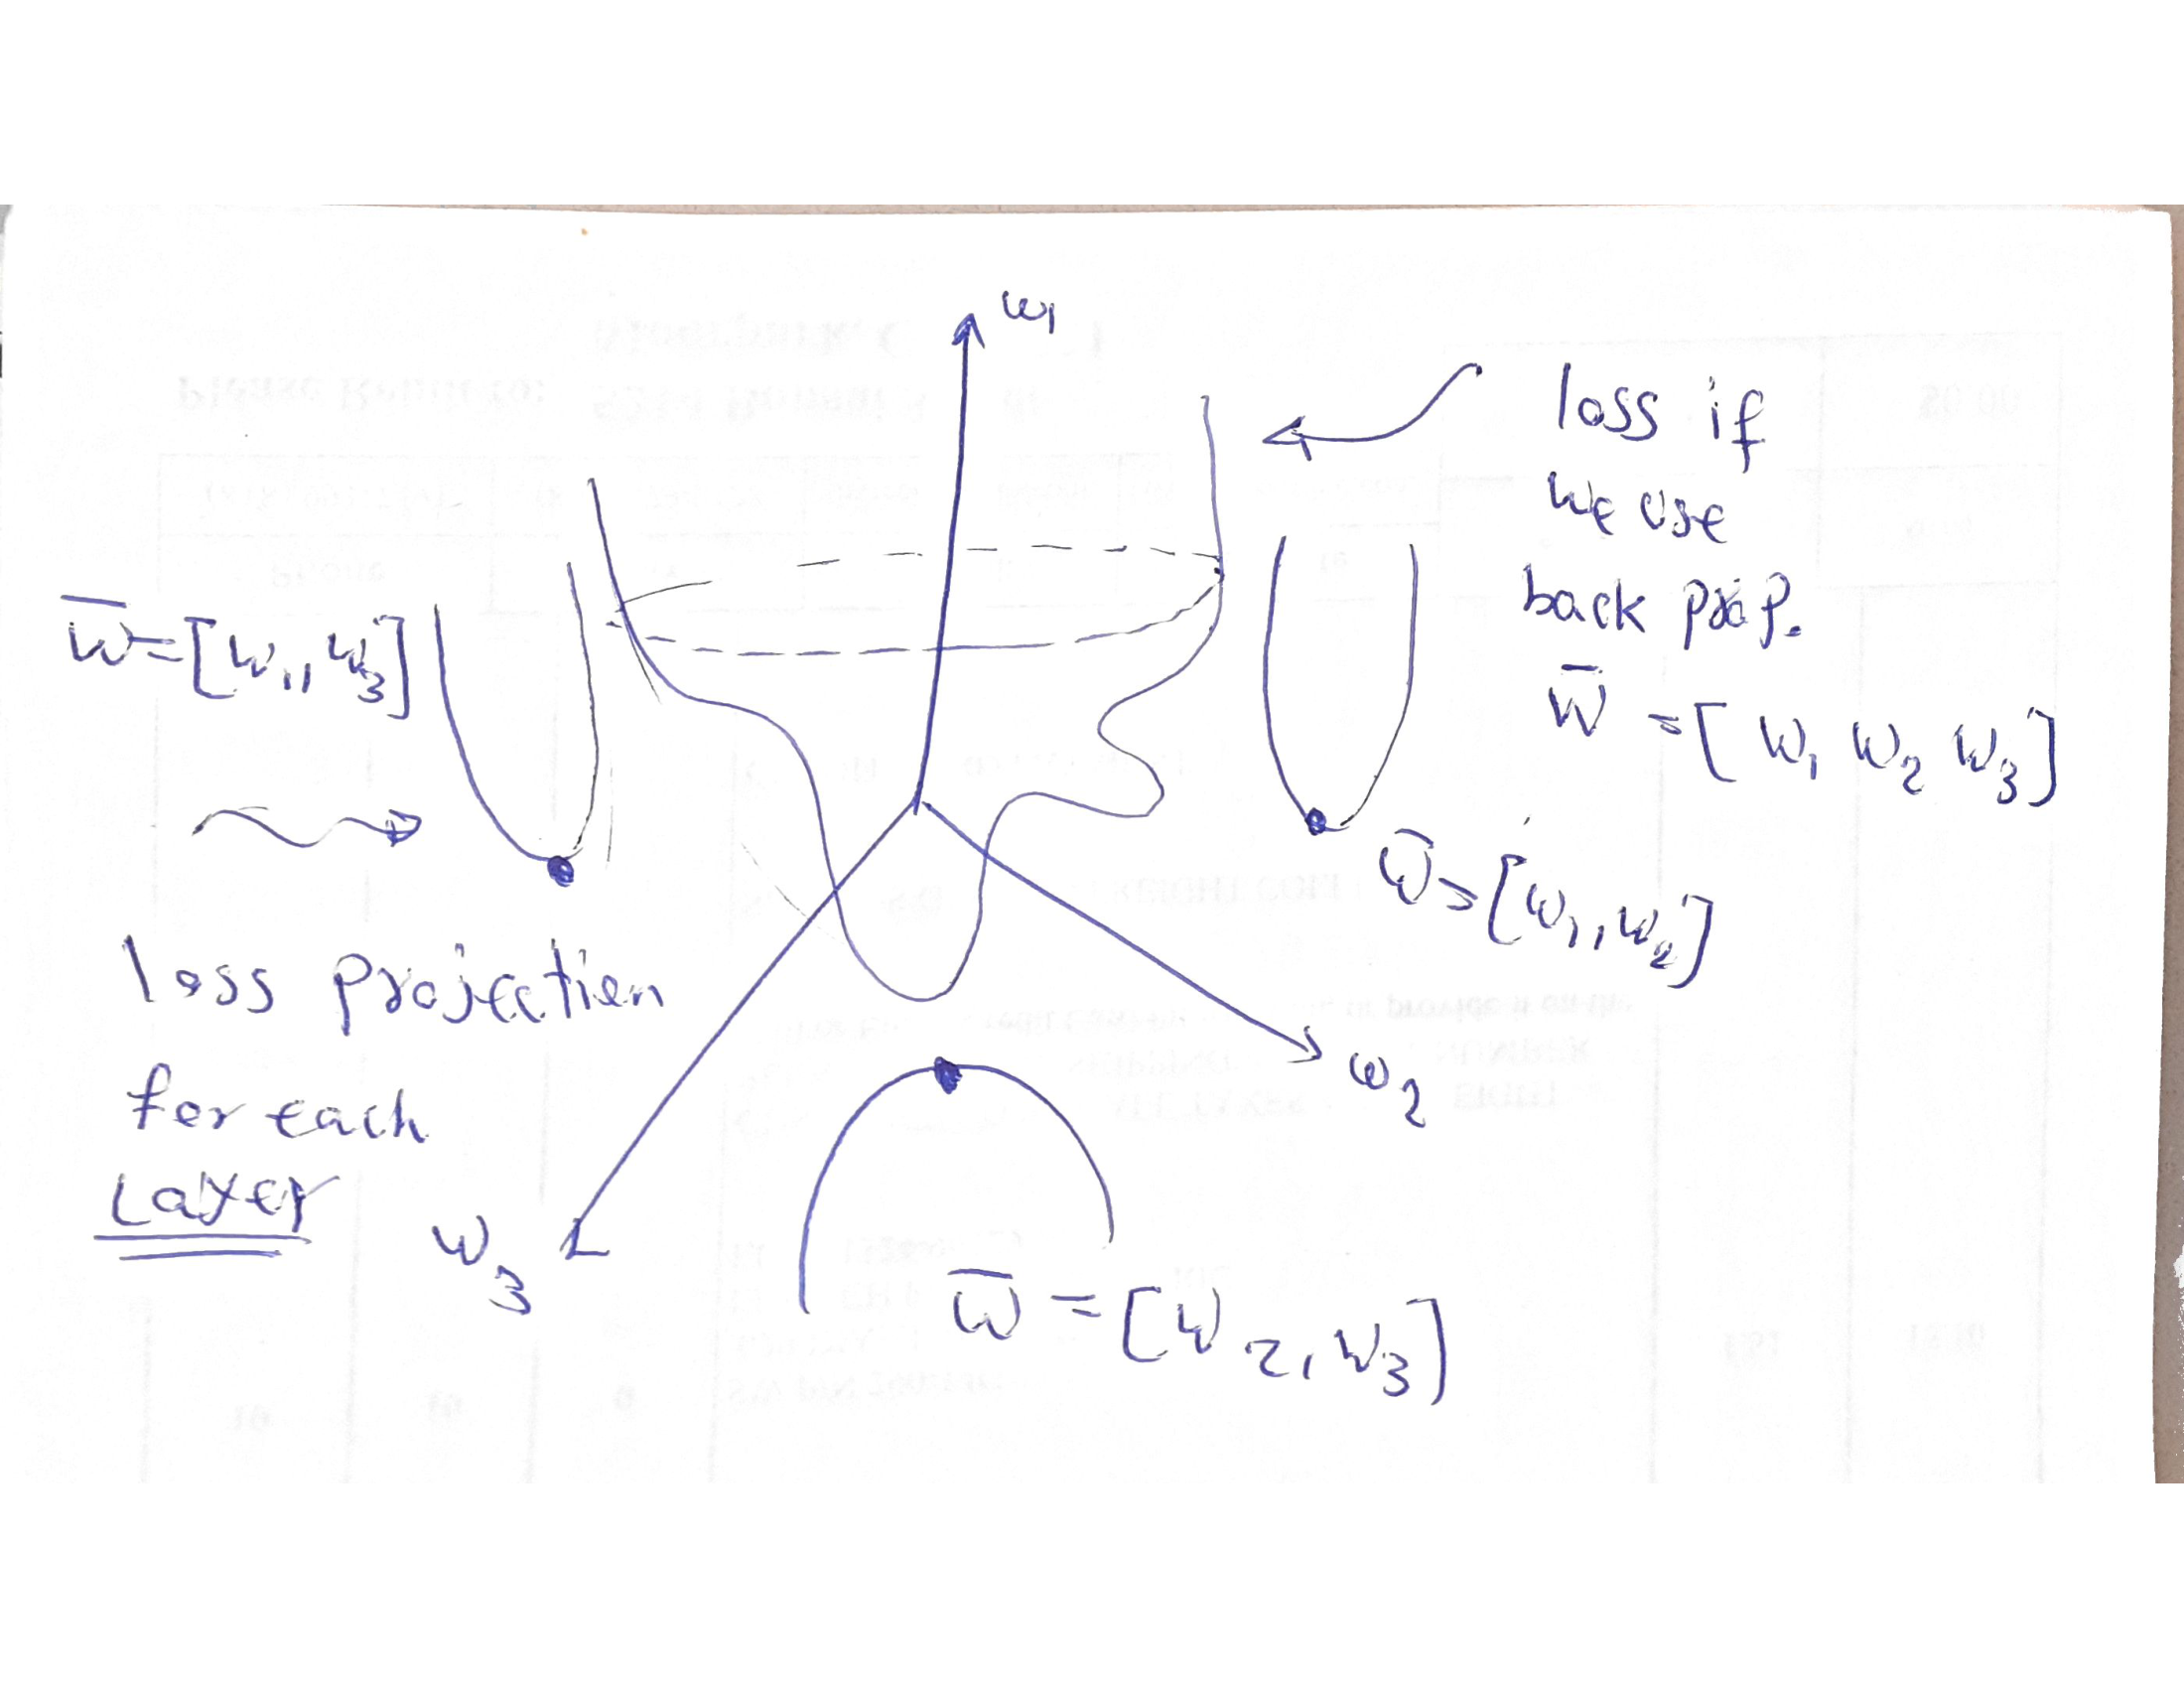

## **Just Class Embdding Visulaization!**
In this section firstly an example is provided to show that how an embeding strategy of a class sample in the Audio Mnist dataset is employed.
For example, using onehot encoding approach is to simply locate a value in the first 10 samples of the time series. For the positive sample, the `x.max()` is located on the correct class location, and for negative sample `x.max()` is located on a wrong (randomly) selected class index in the timeserie. Following provides an simple example on data visualization.

x {'wave': tensor([[-0.0002, -0.0001, -0.0001,  ...,  0.0000,  0.0000,  0.0000]]), 'label': tensor([7])}
tensor(7)
p1 tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor(0.)
tensor(7)
p1 tensor([0., 0., 0.,  ..., 0., 0., 0.])
7
p1 tensor([0., 0., 0.,  ..., 0., 0., 0.])


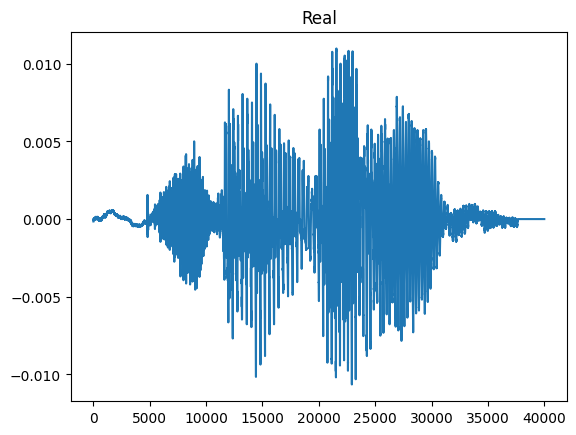

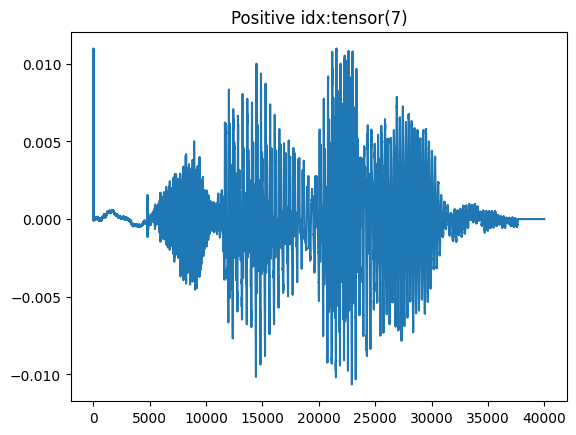

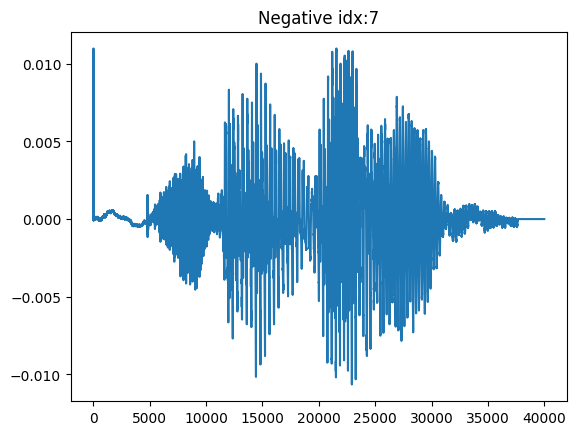

In [ ]:

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

def label_merger(time_series,  label):
  """
  one hot encoding of the input in the first section of the time series

  We can use other embedding stratiegies. I used this one as the simplest one.
  Probably some thing like positional encoding works which encodes the data into the
  signal. But I am not sure.
  """
  time_series = time_series
  time_series[0:10] = 0
  print(label)
  time_series[label] = torch.max(time_series )
  print('p1',time_series.to('cpu'))
  return time_series
  #return time_series.unsqueeze(dim=0)

Dataset = Audio_MNIST_Dataset('./AudioMNIST/data')

Test_Dataset = Audio_MNIST_Dataset('./AudioMNIST/data',train = False)
Train_dataloader = DataLoader(Dataset, batch_size=1,shuffle=True)

Test_dataloader = DataLoader(Test_Dataset, batch_size=1,shuffle=True)

T1 = next(iter(Train_dataloader))
x, y = T1['wave'] , T1['label']
print('x',T1)

plt.figure()
plt.title('Real')
plt.plot(x[0])
x_pos = label_merger(x[0], y[0])
print(x_pos[0])
#x, y = x.to('cuda'), y.to('cuda')
#plt.plot(x.to('cpu')[0])
x_pos = label_merger(x[0], y[0])
plt.figure()
plt.title('Positive idx:' + str(y[0]))
plt.plot(x_pos.to('cpu'))

rnd = random.randint(0,10)
plt.figure()
plt.title('Negative idx:'+ str(rnd))
x_neg = label_merger(x[0], rnd)
plt.plot(x_neg.to('cpu'))

## **Positional Embedding on Spectrogram as a 2d matrix**

Here different embedding approachs is used to embed the class data on spectrogram matrix as a 2d signal. Let S as the spectrogram matrix, and $\alpha$ as a intensity power for label embedding.Then the positional embedding for data is as follows:

$$S = S + \alpha.min(S) $$

You can find some of the different embedding results on the following cell. As you can see with in this approach for positive and nagative samples the labels for different classes 1,2 has preserved different information in the output spectrogram.

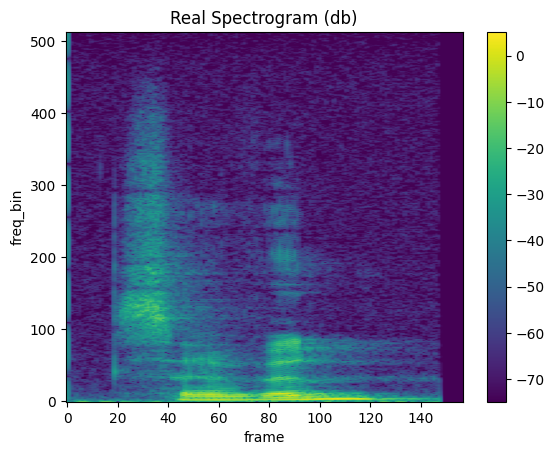

1
tensor([[[-0.0308, -0.0314, -0.0319,  ..., -0.0320, -0.0320, -0.0320],
         [-0.0315, -0.0317, -0.0319,  ..., -0.0320, -0.0320, -0.0320],
         [-0.0319, -0.0319, -0.0317,  ..., -0.0320, -0.0320, -0.0320],
         ...,
         [-0.0315, -0.0318, -0.0320,  ..., -0.0320, -0.0320, -0.0320],
         [-0.0315, -0.0318, -0.0320,  ..., -0.0320, -0.0320, -0.0320],
         [-0.0315, -0.0318, -0.0320,  ..., -0.0320, -0.0320, -0.0320]]])


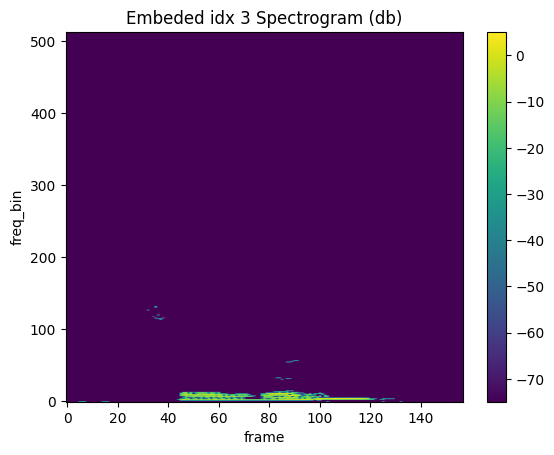

1


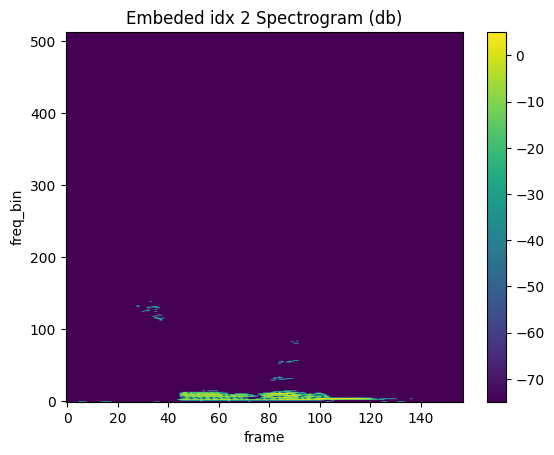

1


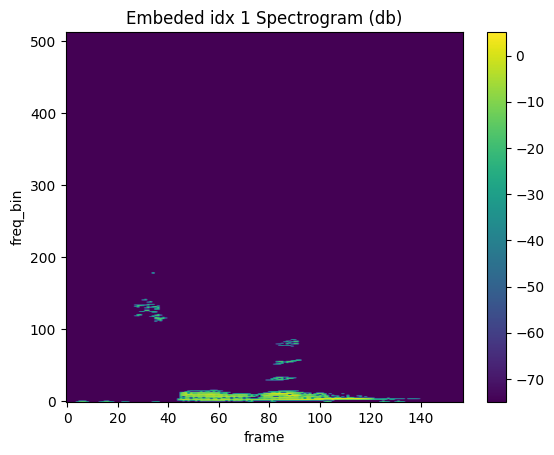

tensor([[-0.0095, -0.0101, -0.0106,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0102, -0.0104, -0.0106,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0106, -0.0106, -0.0104,  ..., -0.0107, -0.0107, -0.0107],
        ...,
        [-0.0102, -0.0105, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0102, -0.0105, -0.0107,  ..., -0.0107, -0.0107, -0.0107],
        [-0.0102, -0.0105, -0.0107,  ..., -0.0107, -0.0107, -0.0107]])


In [ ]:
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa

def overlay_y_on_x(x, y):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    #x_ = x
    x_ = x.clone()
    x_[:, -10:-1] = 0.0
    x_[range(x.shape[0]), -y] = x.max()
    return x_


def label_merger(spec, label):
    """
    Embeds one hot encoding on the class at the end of the spectogram !!

    """
    #x_ = x
    print(spec.shape[0])
    batch_num , spec_x_dim , spec_y_dim = spec.shape[0],spec.shape[1],spec.shape[2]
    x_ = spec.clone()
    #x_[..., -10:-1] = 0.0
    #x_[range(batch_num), :, -label] = x.max()
    if (torch.is_tensor(label)):
      x_  = x_ + x.min()*label.unsqueeze(dim =1).unsqueeze(dim =2)
    else:
      x_  = x_ + x.min()*label
    return x_

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape
    #num_channels = 1
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        _,_,_,specc = axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)
    return specc

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title + " Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    #im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im)
    plt.show(block=False)


n_fft = 1024
win_length = None
hop_length = 256

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

spec = spectrogram(x)

plot_spectrogram(spec[0], title="Real")


spec = spectrogram(x_pos.unsqueeze(0))


p0 = label_merger(spec,3)
print(p0)
plot_spectrogram(p0[0].to('cpu'), title="Embeded idx 3")


#print()
spec = spectrogram(x_neg.unsqueeze(0))
p1 = label_merger(spec,2)
plot_spectrogram(p1[0].to('cpu'), title="Embeded idx 2")


p2 = label_merger(spec,1)
plot_spectrogram(p2[0].to('cpu'), title="Embeded idx 1")

print(p2[0])
#spec = plot_specgram(x,16000)
#print(spec.get_size())
#canvas = plt.gca().figure.canvas
#canvas.draw()
#data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
#print(data.reshape(spec.get_size()))
#p  = overlay_y_on_x(spec, 2)
#plt.plot(p)
#plot_specgram(x_pos.unsqueeze(0),16000)
#plot_specgram(x_neg.unsqueeze(0),16000)

## **AudioMNIST with  1D - CNN Archtiecture!**

In this part a simple 1-d CNN archtecture is used to simulate the forward froward algorithm. Here Onehot encoding is considered to embed the labels in the time serie data as well.

**Based on the talk with professor Ravanelli, I removed the MLP layer, and only the CNN layers compute the Likelihood. For the experiments here.**

In [ ]:

import torchaudio.functional as F
import torchaudio.transforms as T
import librosa

def label_merger(time_series,  label):
  """
  one hot encoding of the input in the first section of the time series

  We can use other embedding stratiegies. I used this one as the simplest one.
  Probably some thing like positional encoding works which encodes the data into the
  signal. But I am not sure.
  """
  time_series[:,0:10] = 0
  #print('Label',label)
  out, inds = torch.max(time_series,dim=1)
  #print('Shape',a)
  time_series[:,label] = out
  #print('p1',time_series.to('cpu'))
  return time_series.unsqueeze(dim=1)


class FW_Lin_layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=False, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0#2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1) # across feature dimention
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()







class FW_Conv1d_layer(nn.Conv1d):
    def __init__(self, in_channels, out_channels,
             kernel_size, device=None, dtype=None):
        super().__init__(in_channels, out_channels,kernel_size, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 5.0  # 2.0
        self.num_epochs = 35
        self.kernel_size = kernel_size

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            #print('SHAPE g_pos g_neg',  self.forward(x_pos).pow(2).mean(2).shape)
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            #loss = torch.cat([
            #    -g_pos + self.threshold,
            #    g_neg - self.threshold])
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

    def forward(self,x):
      x = x / (x.norm(2, 1, keepdim=True) + 1e-4)
      return self.relu(torch.nn.functional.conv1d(x, self.weight.to('cuda:0')))



class Conv1D_NeuralNet(torch.nn.Module):

    def __init__(self,kernel_size,device):
        super().__init__()
        self.device = device
        self.layer_list = []
        self.layer_list.append( FW_Conv1d_layer(in_channels=1,
                                                out_channels=20,
                                                kernel_size=kernel_size,
                                                device =self.device))
        self.layer_list.append( FW_Conv1d_layer(in_channels=20,
                                                out_channels=15,
                                                kernel_size=kernel_size,
                                                device =self.device))
        self.layer_list.append( FW_Conv1d_layer(in_channels=15,
                                                out_channels=6,
                                               kernel_size=kernel_size,
                                                device =self.device))



    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = label_merger(x, label)
            goodness = []
            for layer in self.layer_list:
                h = layer(h)

                #print('H shape', h.shape)
                h_ = h.view(h.shape[0],-1).mean(1)
                #print('HHH' ,  h_)
                #print('Goodness SHAP',  h.view(h.shape[0],-1).mean(1))
                #goodness += [h.pow(2).mean(1)]
                #print('Goodness SHAP',  h_.shape)
                goodness += [h_]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        #print('GG--LL',goodness_per_label)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layer_list):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
    def my_test(self,x):

        for i , layer in enumerate(self.layer_list):
          print('forwarding layer ...', i)
          x = layer.forward(x)
          print('shape forward',x.shape)
          if(i == len(self.layer_list)-1):
            FLT = nn.Flatten()
            x = FLT(x)
            FC_layer = FW_Lin_layer(in_features=x.shape[1],
                         out_features=200,
                         device = self.device)
            x = FC_layer(x)
            print(x.shape)


if __name__ == "__main__":

  Dataset = Audio_MNIST_Dataset('./AudioMNIST/data')

  Test_Dataset = Audio_MNIST_Dataset('./AudioMNIST/data',train = False)
  Train_dataloader = DataLoader(Dataset, batch_size=90,shuffle=True)

  Test_dataloader = DataLoader(Test_Dataset, batch_size=50,shuffle=True)


  net = Conv1D_NeuralNet(47,device=  'cuda:0')

  from itertools import islice
  tr_err = []
  for i,T_ in enumerate(islice(Train_dataloader,20)):
    print('Batch:' , (i))
    x, y = T_['wave'] , T_['label']
    x, y = x.cuda(), y.cuda()
    x_pos = label_merger(x, y)
    rnd = random.randint(0,10)
    x_neg = label_merger(x, torch.randint(0, 10, (x.shape[0],)))
    net.train(x_pos, x_neg)
    pered_train =  net.predict(x).detach()
    tr_err.append(pered_train.eq(y).float().mean().item())

  print('train error:', 1.0 - sum(tr_err) / len(tr_err))



  T2 = next(iter(Test_dataloader))
  x_te, y_te = T2['wave'].cuda(), T2['label'].cuda()

  pered_te = net.predict(x_te).detach()
  print('test error:', 1.0 - pered_te.eq(y_te).float().mean().item())

  print('TEST STAT: pred_te , y_te',pered_te,y_te  )



Batch: 0
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.53it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.87it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.59it/s]


Batch: 1
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.94it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.82it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.53it/s]


Batch: 2
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.84it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.78it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.48it/s]


Batch: 3
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.79it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.73it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.36it/s]


Batch: 4
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.65it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.69it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.36it/s]


Batch: 5
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.51it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.65it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.29it/s]


Batch: 6
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.40it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.60it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.23it/s]


Batch: 7
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.41it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.21it/s]


Batch: 8
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.49it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 9
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.48it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 10
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.51it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 11
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.41it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.57it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.21it/s]


Batch: 12
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.45it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.21it/s]


Batch: 13
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.47it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 14
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.51it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 15
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.44it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 16
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.45it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 17
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.44it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 18
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.39it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


Batch: 19
training layer 0 ...


100%|██████████| 35/35 [00:02<00:00, 16.39it/s]


training layer 1 ...


100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


training layer 2 ...


100%|██████████| 35/35 [00:06<00:00,  5.22it/s]


train error: 0.8933333305642008
test error: 0.9000000059604645
TEST STAT: pred_te , y_te tensor([5, 9, 9, 7, 9, 6, 9, 9, 9, 9, 9, 9, 7, 9, 7, 9, 9, 9, 7, 7, 7, 9, 7, 8,
        9, 9, 6, 9, 5, 9, 8, 9, 9, 9, 9, 7, 9, 9, 7, 7, 7, 7, 9, 4, 7, 9, 8, 9,
        7, 7], device='cuda:0') tensor([6, 4, 1, 0, 3, 2, 7, 8, 8, 3, 9, 0, 1, 2, 3, 5, 9, 1, 1, 1, 8, 9, 5, 3,
        5, 7, 9, 8, 3, 5, 5, 0, 9, 2, 7, 4, 5, 3, 2, 4, 9, 2, 9, 3, 4, 1, 5, 3,
        9, 4], device='cuda:0')


## **1D-CNN Variation getting mean accross time**

In this section the mean value across the time axis has been carried out. For example:
`g_pos = self.forward(x_pos).pow(2).mean(2)`

In [ ]:

def data_prepration (addr):

  return None



def label_merger(time_series,  label):
  """
  one hot encoding of the input in the first section of the time series

  We can use other embedding stratiegies. I used this one as the simplest one.
  Probably some thing like positional encoding works which encodes the data into the
  signal. But I am not sure.
  """
  time_series[:,0:10] = 0
  #print('Label',label)
  out, inds = torch.max(time_series,dim=1)
  #print('Shape',a)
  time_series[:,label] = out
  #print('p1',time_series.to('cpu'))
  return time_series.unsqueeze(dim=1)


class FW_Lin_layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=False, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0#2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(2)# accross time dimension
            g_neg = self.forward(x_neg).pow(2).mean(2)
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()






class FW_Conv1d_layer(nn.Conv1d):
    def __init__(self, in_channels, out_channels,
             kernel_size, device=None, dtype=None):
        super().__init__(in_channels, out_channels,kernel_size, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0  # 2.0
        self.num_epochs = 200
        self.kernel_size = kernel_size

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            #print('SHAPE g_pos g_neg',  self.forward(x_pos).pow(2).mean(2).shape)
            g_pos = self.forward(x_pos).pow(2).mean(2)# accross time dimension
            g_neg = self.forward(x_neg).pow(2).mean(2)
            #loss = torch.cat([
            #    -g_pos + self.threshold,
            #    g_neg - self.threshold])
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

    def forward(self,x):
      x = x / (x.norm(2, 1, keepdim=True) + 1e-4)
      return self.relu(torch.nn.functional.conv1d(x, self.weight.to('cuda:0')))



class Conv1D_NeuralNet(torch.nn.Module):

    def __init__(self,kernel_size,device):
        super().__init__()
        self.device = device
        self.layer_list = []
        self.layer_list.append( FW_Conv1d_layer(in_channels=1,
                                                out_channels=15,
                                                kernel_size=kernel_size,
                                                device =self.device))
        self.layer_list.append( FW_Conv1d_layer(in_channels=15,
                                                out_channels=10,
                                                kernel_size=kernel_size,
                                                device =self.device))
        self.layer_list.append( FW_Conv1d_layer(in_channels=10,
                                                out_channels=6,
                                               kernel_size=kernel_size,
                                                device =self.device))



    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = label_merger(x, label)
            goodness = []
            for layer in self.layer_list:
                h = layer(h)

                #print('H shape', h.shape)
                h_ = h.view(h.shape[0],-1).pow(2).mean(1)
                #print('HHH' ,  h_)
                #print('Goodness SHAP',  h.view(h.shape[0],-1).mean(1))
                #goodness += [h.pow(2).mean(1)]
                #print('Goodness SHAP',  h_.shape)
                goodness += [h_]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        #print('GG--LL',goodness_per_label)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layer_list):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)

    def my_test(self,x):

        for i , layer in enumerate(self.layer_list):
          print('forwarding layer ...', i)
          x = layer.forward(x)
          print('shape forward',x.shape)
          if(i == len(self.layer_list)-1):
            FLT = nn.Flatten()
            x = FLT(x)
            FC_layer = FW_Lin_layer(in_features=x.shape[1],
                         out_features=200,
                         device = self.device)
            x = FC_layer(x)
            print(x.shape)


if __name__ == "__main__":
  Dataset = Audio_MNIST_Dataset('./AudioMNIST/data')

  Test_Dataset = Audio_MNIST_Dataset('./AudioMNIST/data',train = False)
  Train_dataloader = DataLoader(Dataset, batch_size=50,shuffle=True)

  Test_dataloader = DataLoader(Test_Dataset, batch_size=50,shuffle=True)


  net = Conv1D_NeuralNet(47,device=  'cuda:0')



  #print('LEN TRAIN',len(Train_dataloader))
  from itertools import islice
  tr_err = []
  for i,T_ in enumerate(islice(Train_dataloader,20)):
    print('Batch:' , (i))
    x, y = T_['wave'] , T_['label']
    x, y = x.cuda(), y.cuda()
    x_pos = label_merger(x, y)
    rnd = random.randint(0,10)
    x_neg = label_merger(x, torch.randint(0, 10, (x.shape[0],)))
    net.train(x_pos, x_neg)
    pered_train =  net.predict(x).detach()
    tr_err.append(pered_train.eq(y).float().mean().item())

  print('train error:', 1.0 - sum(tr_err) / len(tr_err))


  T2 = next(iter(Test_dataloader))
  x_te, y_te = T2['wave'].cuda(), T2['label'].cuda()

  pered_te = net.predict(x_te).detach()
  print('test error:', 1.0 - pered_te.eq(y_te).float().mean().item())

  print('TEST STAT: pred_te , y_te',pered_te,y_te  )



Batch: 0
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 37.08it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.60it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


Batch: 1
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.19it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.42it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


Batch: 2
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 39.13it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.54it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Batch: 3
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.98it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Batch: 4
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 39.18it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


Batch: 5
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.98it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


Batch: 6
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.93it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.50it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


Batch: 7
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.83it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.70it/s]


Batch: 8
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.98it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.45it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Batch: 9
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 39.11it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Batch: 10
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 39.16it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


Batch: 11
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.88it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Batch: 12
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.90it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


Batch: 13
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.91it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.51it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


Batch: 14
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.90it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.73it/s]


Batch: 15
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 39.14it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.44it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


Batch: 16
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 39.00it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


Batch: 17
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 39.05it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.77it/s]


Batch: 18
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.98it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.50it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


Batch: 19
training layer 0 ...


100%|██████████| 200/200 [00:05<00:00, 38.78it/s]


training layer 1 ...


100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


training layer 2 ...


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


train error: 0.9030000025406479
test error: 0.9400000013411045
TEST STAT: pred_te , y_te tensor([9, 0, 9, 0, 9, 0, 9, 0, 0, 0, 9, 9, 0, 6, 9, 0, 9, 9, 9, 8, 9, 9, 9, 6,
        8, 9, 9, 0, 9, 0, 9, 9, 0, 0, 0, 0, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9], device='cuda:0') tensor([1, 7, 5, 8, 2, 7, 1, 4, 5, 6, 7, 7, 6, 3, 8, 4, 8, 5, 3, 7, 9, 0, 5, 5,
        7, 2, 5, 0, 6, 0, 3, 0, 1, 9, 6, 4, 3, 7, 8, 5, 4, 4, 1, 1, 5, 1, 1, 2,
        9, 5], device='cuda:0')


## **2D-CNN and testing on Spectogram!**

Here the 2-D CNN is used to test the forward forward algorithm on Audio dataset. Meanwhile, The input raw wave form should be transformed to Mel spectrogram to capture the informative frequency content as well. We also downsample the Mel spectrogram matrix to a lowe dimension for memory usage allocation on GPU.  In addition, The structure of the 2-d CNN using forward-forward algorithm is as follows : $\{256, 128,64\}$. And for embeding the layer, positional embedding as discussed has been used.

**Based on the talk with professor Ravanelli, I did not used the MLP layer here, and only the CNN layers compute the Likelihood for us.**

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

import numpy as np
import pandas as pd

import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm


feature_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((90,90)),
    T.ToTensor()
])

label_transform = T.Compose([
    T.ToTensor()
])
CHAN_SIZE = 128

def MelSpec(path):
    audio, fs = librosa.load(path)
    return librosa.feature.melspectrogram(y =audio, sr = fs)

class AudioMNIST_CNN(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None, train=True, train_size=0.80):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))

        total_len = len(self.file_list)

        if train:
            self.file_list, self.label_list = self.file_list[:int(0.80 * total_len)], self.label_list[:int(0.80 * total_len)]
        else:
            self.file_list, self.label_list = self.file_list[int(0.80 * total_len):], self.label_list[int(0.80 * total_len):]

    def __getitem__(self, idx):
        try:
            spec = MelSpec(self.file_list[idx])
            #wav = load_wav(self.file_list[idx])
            #spec = spectrogram(wav)
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return {'spec':spec, 'label':label, 'path':self.file_list[idx]}
        except:
            spec = MelSpec(self.file_list[0])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return {'spec':spec, 'label':label, 'path':self.file_list[idx]}

    def __len__(self):
        return len(self.file_list)



def label_merger(spec, label):
    """
    Embeds one hot encoding on the class at the end of the spectogram !!

    """
    #x_ = x
    #print(spec.shape[0])
    batch_num , spec_x_dim , spec_y_dim = spec.shape[0],spec.shape[1],spec.shape[2]
    x_ = spec.clone()
    #x_[..., -10:-1] = 0.0
    #x_[range(batch_num), :, -label] = x.max()
    if (torch.is_tensor(label)):
      x_  = x_ + x.min()*label.unsqueeze(dim =1).unsqueeze(dim =2).to('cuda:0')
    else:
      x_  = x_ + x.min()*label
    return x_.unsqueeze(dim =1)


def label_merger2(spec, label):
    """
    Embeds one hot encoding on the class at the end of the spectogram !!

    """
    #x_ = x
    #print(spec.shape[0])
    batch_num , spec_x_dim , spec_y_dim = spec.shape[0],spec.shape[1],spec.shape[2]
    x_ = spec.clone()
    #x_[..., -10:-1] = 0.0
    #x_[range(batch_num), :, -label] = x.max()
    if (torch.is_tensor(label)):
      #print(x.min().shape,label.shape,  x.shape)
      #x.unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, 1, 200,200)
      x_  = x_ + torch.min(x)*label.unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, 1, x.shape[-2],x.shape[-1]).to('cuda:0')
    else:
      x_  = x_ + torch.min(x)*label
    return x_


class FW_Lin_layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=False, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0#2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1) # across feature dimention
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()






class FW_Conv2d_layer(nn.Conv2d):
    def __init__(self, in_channels, out_channels,
             kernel_size, device=None, dtype=None):
        super().__init__(in_channels, out_channels,kernel_size, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 5  # 2.0
        self.num_epochs = 5
        self.kernel_size = kernel_size

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            #print('SHAPE g_pos g_neg',  self.forward(x_pos).pow(2).mean(2).shape)
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            #loss = torch.cat([
            #    -g_pos + self.threshold,
            #    g_neg - self.threshold])
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

    def forward(self,x):
      x = x / (x.norm(2, 1, keepdim=True) + 1e-4)
      return self.relu(torch.nn.functional.conv2d(x, self.weight.to('cuda:0')))



class Conv2D_NeuralNet(torch.nn.Module):

    def __init__(self,kernel_size,device):
        super().__init__()
        self.device = device
        self.layer_list = []
        self.layer_list.append( FW_Conv2d_layer(in_channels=1,
                                                out_channels=CHAN_SIZE,
                                                kernel_size=kernel_size,
                                                device =self.device))
        self.layer_list.append( FW_Conv2d_layer(in_channels=CHAN_SIZE,
                                                out_channels=CHAN_SIZE//2,
                                                kernel_size=kernel_size,
                                                device =self.device))
        self.layer_list.append( FW_Conv2d_layer(in_channels=CHAN_SIZE//2,
                                                out_channels=CHAN_SIZE//4,
                                               kernel_size=kernel_size,
                                                device =self.device))



    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            #x_sq = x.squeeze()
            h = label_merger(x, label)
            goodness = []
            for layer in self.layer_list:
                h = layer(h)

                #print('H shape', h.shape)
                h_ = torch.nn.functional.normalize(
                    h.view(h.shape[0],-1).pow(2)).mean(1)
                #print('HHH' ,  h_)
                #print('Goodness SHAP',  h_)
                #goodness += [h.pow(2).mean(1)]
                #print('Goodness SHAP',  h_.shape)
                #h_ = h.view(h.shape[0],-1).pow(2).mean(1)
                goodness += [h_]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        #print('BEFORE CAT',goodness_per_label)
        goodness_per_label = torch.cat(goodness_per_label, 1)
        #print('GG--LL',goodness_per_label)
        return goodness_per_label.argmax(1)


    def predict2(self, x):
        goodness_per_label = []
        #print('XX',x)
        for label in range(10):
            #x_sq = x.squeeze()
            h = label_merger2(x, label)
            #print('HH',h)
            goodness = []
            for k,layer in enumerate(self.layer_list):
                h = layer(h)
                h = torch.nan_to_num(h)
                btch_nrm = nn.BatchNorm2d((h.shape[1])).to('cuda:0')
                #print(btch_nrm, k,h.shape[1] )
                h = btch_nrm(h)


                #print('H shape', h)
                h_ = torch.nn.functional.normalize(
                    h.view(h.shape[0],-1).pow(2)).mean(1)
                #print('HHH' ,  h_)
                #print('Goodness SHAP',  h_)
                #goodness += [h.pow(2).mean(1)]
                #print('Goodness SHAP',  h_.shape)
                #h_ = h.view(h.shape[0],-1).pow(2).mean(1)
                goodness += [h_]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        #print('BEFORE CAT',goodness_per_label)
        goodness_per_label = torch.cat(goodness_per_label, 1)
        #print('GG--LL',goodness_per_label)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layer_list):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
    def my_test(self,x):

        for i , layer in enumerate(self.layer_list):
          print('forwarding layer ...', i)
          x = layer.forward(x)
          #print('shape forward',x.shape)
          if(i == len(self.layer_list)-1):
            FLT = nn.Flatten()
            x = FLT(x)
            FC_layer = FW_Lin_layer(in_features=x.shape[1],
                         out_features=200,
                         device = self.device)
            x = FC_layer(x)
            print(x.shape)


if __name__ == "__main__":
# test Audio_MNIST Dataset
  #torch.manual_seed(1234)
  torch.cuda.empty_cache()
  device = 'cuda:0'
  # Dataset = Audio_MNIST_Dataset('./AudioMNIST/data')

  # Test_Dataset = Audio_MNIST_Dataset('./AudioMNIST/data',train = False)
  # Train_dataloader = DataLoader(Dataset, batch_size=50,shuffle=True)

  # Test_dataloader = DataLoader(Test_Dataset, batch_size=50,shuffle=True)


  train_ds = AudioMNIST_CNN('/content/AudioMNIST/data', feature_transform=feature_transform,
                          label_transform=T.ToTensor(), train=True)

  test_ds = AudioMNIST_CNN('/content/AudioMNIST/data', feature_transform=feature_transform,
                         label_transform=T.ToTensor(), train=False)

  print(len(train_ds), len(test_ds))
  train_dataloader = DataLoader(train_ds, batch_size=50, shuffle=True)
  test_dataloader = DataLoader(test_ds, batch_size=50, shuffle=True)

  net = Conv2D_NeuralNet((12,12),device=  device)


  Train_dataloader = train_dataloader
  Test_dataloader = test_dataloader



  T1= next(iter(Train_dataloader))
  x, y = T1['spec'] , T1['label']
  #print('SHAPE spec',T1['spec'])
  #x, y = x.cuda(), y.cuda()
  # #print(x.shape)
  # #window  = torch.hamming_window(window_length = None, device = "cuda")
  # n_fft = 1024
  # win_length = None
  # hop_length = 128
  # spectrogram = T.Spectrogram(
  #   n_fft=n_fft,
  #   win_length=win_length,
  #   hop_length=hop_length,
  #   center=True,
  #   pad_mode="reflect",
  #   power=2.0
  # ).to(device)





  from itertools import islice
  tr_err = []
  #for i,T_ in enumerate(islice(Train_dataloader,20)):
  for i,T_ in enumerate(Train_dataloader):
    print('Batch:----------------' , (i))
    #x, y = T_['wave'] , T_['label']
    x, y = T_['spec'] , T_['label']

    x,y = x.cuda(), y.cuda()
    spec = x

    #spec = spectrogram(x)
    spec_pos = label_merger2(spec, y)
    #print('SPEC pos shape',spec_pos.shape)
    rnd = random.randint(0,10)

    spec_neg = label_merger2(spec, torch.randint(0, 10, (x.shape[0],)))
    net.train(spec_pos, spec_neg)
    pered_train =  net.predict2(spec).detach()
    tr_err.append(pered_train.eq(y).float().mean().item())

  print('train error:', 1.0 - sum(tr_err) / len(tr_err))

  #spec = spectrogram(x)
  ##plot_spectrogram(spec[36].to('cpu'), title="Embed 1")
  ##plot_spectrogram(spec[16].to('cpu'), title="Embed 1")
  #print(y)
  #spec_pos = label_merger(spec, y)
  ##print('dsadsadas',spec_pos.shape)
  ##print(spec_pos.squeeze()[0])
  ##print(x_pos.squeeze().shape)
  ##plot_spectrogram(spec_pos.squeeze()[1].to('cpu'), title="Embed 1")
  ##plot_spectrogram(spec_pos.squeeze()[34].to('cpu'), title="Embed 1")
  ##print('X_POS SHAPE', (spec_pos.shape))
  #rnd = random.randint(0,10)
  #  #rnd = torch.randperm(x.size(0))
  #  #plt.figure
  #spec_neg = label_merger(spec, torch.randint(0, 10, (x.shape[0],)))
  #print('X_NEG SHAPE', spec_neg.shape)
  ##net.my_test(x_pos)
  #net.train(spec_pos, spec_neg)


  #pered_train =  net.predict(spec).detach()
  #print('train error:', 1.0 - pered_train.eq(y).float().mean().item())
  #print('TRAIN STAT: pred_train , y_train',pered_train,y  )


  T2 = next(iter(Test_dataloader))
  #x_te, y_te = T2['wave'].cuda(), T2['label'].cuda()
  x_te, y_te = T2['spec'].cuda(), T2['label'].cuda()
  #spec_te = spectrogram(x_te)
  spec_te = x_te
  pered_te = net.predict2(spec_te).detach()
  print('test error:', 1.0 - pered_te.eq(y_te).float().mean().item())

  #print('TEST STAT: pred_te , y_te',pered_te,y_te  )



24000 6000
Batch:---------------- 0
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 1
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.74it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 2
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 3
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 4
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 5
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.00it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


Batch:---------------- 6
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.54it/s]


Batch:---------------- 7
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.39it/s]


Batch:---------------- 8
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.32it/s]


Batch:---------------- 9
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.55it/s]


Batch:---------------- 10
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 11
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 12
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.03it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 13
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 14
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Batch:---------------- 15
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.04it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 16
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Batch:---------------- 17
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 18
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


Batch:---------------- 19
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


Batch:---------------- 20
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.44it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 21
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.42it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Batch:---------------- 22
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 23
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


Batch:---------------- 24
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 25
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 26
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 27
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 28
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 29
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.55it/s]


Batch:---------------- 30
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 31
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 32
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 33
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 34
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 35
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 36
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 37
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.59it/s]


Batch:---------------- 38
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 39
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.00it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Batch:---------------- 40
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 41
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.54it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 42
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 43
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 44
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 45
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.07it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 46
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 47
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 48
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 49
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 50
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 51
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 52
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.53it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 53
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 54
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.44it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 55
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 56
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 57
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 58
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.45it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 59
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.47it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 60
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 61
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 62
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 63
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.57it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 64
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.57it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 65
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.45it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 66
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 67
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.56it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 68
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.17it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 69
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 70
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


Batch:---------------- 71
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 72
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 73
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 74
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 75
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 76
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 77
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 78
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 79
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 80
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


Batch:---------------- 81
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 82
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 83
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.47it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 84
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.58it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


Batch:---------------- 85
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 86
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 87
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 88
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 89
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 90
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 91
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


Batch:---------------- 92
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 93
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 94
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 95
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 96
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 97
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 98
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.55it/s]


Batch:---------------- 99
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.35it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 100
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.22it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 101
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.72it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.59it/s]


Batch:---------------- 102
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 103
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 104
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.48it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.42it/s]


Batch:---------------- 105
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 106
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Batch:---------------- 107
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.14it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.47it/s]


Batch:---------------- 108
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 109
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 110
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 111
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 112
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.53it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.54it/s]


Batch:---------------- 113
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.32it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 114
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 115
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 116
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.57it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 117
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 118
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 119
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 120
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.52it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 121
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 122
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 123
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 124
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 125
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 126
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 127
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 128
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 129
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 130
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 131
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 132
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 133
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 134
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Batch:---------------- 135
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 136
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 137
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 138
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 139
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 140
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.37it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 141
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Batch:---------------- 142
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.99it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 143
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 144
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 145
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 146
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 147
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.32it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


Batch:---------------- 148
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 149
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 150
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.49it/s]


Batch:---------------- 151
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.47it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 152
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 153
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 154
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 155
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.49it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 156
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 157
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 158
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.38it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 159
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


Batch:---------------- 160
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 161
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 162
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 16.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.49it/s]


Batch:---------------- 163
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.33it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 164
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 165
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.16it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 166
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 167
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 168
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.03it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 169
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 170
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 171
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Batch:---------------- 172
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 173
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 174
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 175
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.43it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 176
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 16.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 177
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.58it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 178
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 179
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 180
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 181
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 182
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Batch:---------------- 183
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 184
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 185
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.51it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 186
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 187
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 188
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 189
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 190
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.23it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 191
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.72it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 192
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 193
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.57it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 194
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 195
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 196
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.61it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Batch:---------------- 197
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.37it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 198
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.54it/s]


Batch:---------------- 199
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 200
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 201
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 202
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 203
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.55it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 204
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.58it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 205
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.47it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 206
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 207
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


Batch:---------------- 208
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 209
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.65it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 210
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.53it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 211
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 212
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Batch:---------------- 213
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 214
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.21it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


Batch:---------------- 215
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 216
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 217
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


Batch:---------------- 218
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 219
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 220
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.77it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 221
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.00it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 222
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 223
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Batch:---------------- 224
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 225
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.44it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 226
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 227
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 228
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Batch:---------------- 229
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.27it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 230
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 231
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.54it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 232
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 233
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 234
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 235
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 236
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 237
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 238
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 239
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.90it/s]


Batch:---------------- 240
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 241
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 242
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 243
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 244
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 245
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 246
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 247
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 248
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.87it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Batch:---------------- 249
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 250
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.61it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 251
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.23it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 252
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 253
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 254
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 255
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 256
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 257
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 258
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 259
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 260
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 261
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 262
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.99it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 263
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.54it/s]


Batch:---------------- 264
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 16.78it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 265
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.48it/s]


Batch:---------------- 266
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


Batch:---------------- 267
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.84it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 268
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 269
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 270
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


Batch:---------------- 271
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.59it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 272
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 273
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 274
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.68it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 275
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.22it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 276
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 277
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 278
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.39it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 279
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.50it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 280
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.10it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 281
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 282
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 283
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 284
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.23it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 285
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 286
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 287
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 288
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 289
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.54it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 290
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.06it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 291
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 292
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.05it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 293
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.58it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 294
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 295
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 296
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.81it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 297
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 298
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 299
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 300
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.06it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 301
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 302
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 303
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 304
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 305
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.61it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 306
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 307
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.88it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 308
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 309
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.55it/s]


Batch:---------------- 310
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 311
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 312
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 313
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 314
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 315
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.59it/s]


Batch:---------------- 316
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 317
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.51it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 318
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 319
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 320
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 321
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 322
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 323
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.54it/s]


Batch:---------------- 324
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.10it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 325
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.11it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 326
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 327
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 328
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.62it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 329
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


Batch:---------------- 330
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 331
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 332
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 333
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.51it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 334
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 335
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Batch:---------------- 336
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 337
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.68it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


Batch:---------------- 338
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 339
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 340
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.72it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 341
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 342
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 343
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 344
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 345
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 346
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 347
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.52it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.59it/s]


Batch:---------------- 348
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 349
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.87it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 350
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.21it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 351
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 352
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.32it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 353
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


Batch:---------------- 354
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 355
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.58it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 356
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


Batch:---------------- 357
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.31it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 358
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.37it/s]


Batch:---------------- 359
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.79it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 360
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 361
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.43it/s]


Batch:---------------- 362
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 363
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 364
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 365
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 366
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Batch:---------------- 367
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 368
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 16.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 369
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 370
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Batch:---------------- 371
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.91it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 372
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 373
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.12it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 374
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.67it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 375
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 376
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.19it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 377
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.61it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Batch:---------------- 378
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 379
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 380
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 381
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 382
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 383
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 384
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.16it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 385
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.42it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 386
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.80it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 387
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Batch:---------------- 388
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 389
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 390
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 391
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.69it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 392
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.48it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 393
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Batch:---------------- 394
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


Batch:---------------- 395
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 396
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.62it/s]


Batch:---------------- 397
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 398
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 399
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.99it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Batch:---------------- 400
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 401
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 402
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.25it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 403
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 404
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 405
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.73it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


Batch:---------------- 406
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Batch:---------------- 407
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 408
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.56it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 409
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.84it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 410
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 411
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.24it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.47it/s]


Batch:---------------- 412
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 413
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 414
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Batch:---------------- 415
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.26it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Batch:---------------- 416
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.92it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Batch:---------------- 417
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 418
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 419
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 420
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.76it/s]


Batch:---------------- 421
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


Batch:---------------- 422
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 423
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.40it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.64it/s]


Batch:---------------- 424
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 425
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.61it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 426
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 427
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.00it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 428
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 429
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Batch:---------------- 430
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 431
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 432
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 433
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.79it/s]


Batch:---------------- 434
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 435
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


Batch:---------------- 436
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 437
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Batch:---------------- 438
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Batch:---------------- 439
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 440
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.53it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 441
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 442
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 443
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 444
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 445
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 446
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.95it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 447
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 448
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.32it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.56it/s]


Batch:---------------- 449
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Batch:---------------- 450
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Batch:---------------- 451
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 16.77it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 452
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.89it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Batch:---------------- 453
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.62it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Batch:---------------- 454
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.01it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


Batch:---------------- 455
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.01it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


Batch:---------------- 456
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.44it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 457
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.96it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Batch:---------------- 458
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 459
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.58it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Batch:---------------- 460
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.73it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


Batch:---------------- 461
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Batch:---------------- 462
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.23it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 463
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 464
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.50it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


Batch:---------------- 465
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.31it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Batch:---------------- 466
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.15it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 467
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.36it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Batch:---------------- 468
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.68it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 469
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.63it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 470
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.22it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Batch:---------------- 471
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Batch:---------------- 472
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.12it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 473
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Batch:---------------- 474
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


Batch:---------------- 475
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Batch:---------------- 476
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.82it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 477
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.78it/s]


Batch:---------------- 478
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 17.41it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


Batch:---------------- 479
training layer 0 ...


100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


training layer 1 ...


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


training layer 2 ...


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


train error: 0.8967083361620705
test error: 0.9400000013411045


## **2dCNN Backprop!**

In this part we have used the 2-d CNN using Normal back propagation to compare the results with the previous verison which the Forward forward algorithm was employed to train the model. Here the structure for the 2-d CNN version is as follows:
First the input is transformed to the Mel spectrogram, then three CNN layers with shifted channels $\{256,128,64\}$ is structured followed by a MLP with the dimension \{484, 128, 64, 32, 10\} is considered. Ref: [here](https://www.kaggle.com/code/smjishanulislam/audio-mnist-with-pytorch)

By running the below cell, different range of results can be achived based on my observation (test accuracy around 73%- 92%). I think it is due to the network structre and random shuffling of data for the data loaders.  However this back prop version compared to the forward forward method can more simply converge in the parameter optimization process.

For example here, I have provided two runs of the same relization of the 2d CNN with backpropagation to also compare the test accurecies with eachother.

24000 6000
Epoch 0
	Batch 0: Train loss: 2.28978 | Train accuracy : 8.59%
----------------------------------------
	Batch 50: Train loss: 0.20637 | Train accuracy : 91.41%
----------------------------------------
Train loss: 0.47022 | Train accuracy: 84.43%
	Batch 0: Test loss: 1.23156 | Test accuracy : 58.20%
----------------------------------------
Test loss: 1.30690 | Test accuracy: 59.11%
Epoch 1
	Batch 0: Train loss: 0.09699 | Train accuracy : 97.66%
----------------------------------------
	Batch 50: Train loss: 0.04364 | Train accuracy : 98.44%
----------------------------------------
Train loss: 0.08981 | Train accuracy: 97.44%
	Batch 0: Test loss: 2.58244 | Test accuracy : 37.50%
----------------------------------------
Test loss: 2.60008 | Test accuracy: 38.60%
Epoch 2
	Batch 0: Train loss: 0.05352 | Train accuracy : 99.22%
----------------------------------------
	Batch 50: Train loss: 0.03030 | Train accuracy : 99.22%
----------------------------------------
Train loss: 0.0

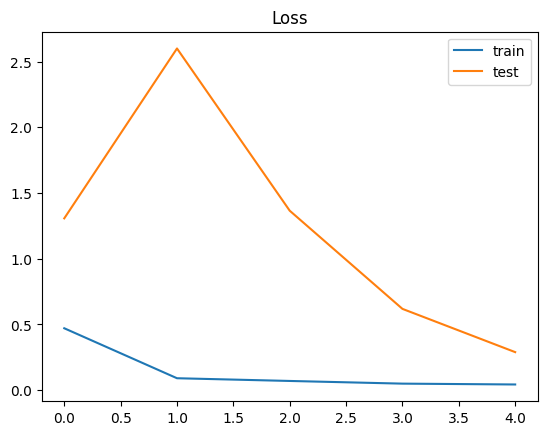

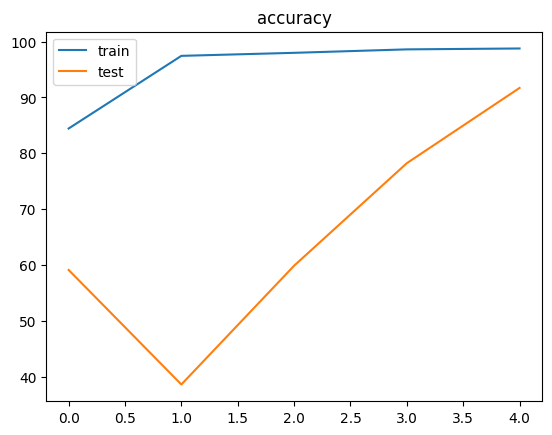

In [ ]:

import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random


import torchaudio.functional as Fa
import torchaudio.transforms as Ta


device = "cuda" if torch.cuda.is_available() else "cpu"


n_fft = 1024
win_length = None
hop_length = 128
spectrogram = Ta.Spectrogram(
  n_fft=n_fft,
  win_length=win_length,
  hop_length=hop_length,
  center=True,
  pad_mode="reflect",
  power=2.0
  ).to(device)

BATCH_SIZE = 256
EPOCHS = 5
LR = 1e-3

feature_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((200,200)),
    T.ToTensor()
])

label_transform = T.Compose([
    T.ToTensor()
])


def load_wav(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return audio

def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)



class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None, train=True, train_size=0.80):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))

        total_len = len(self.file_list)

        if train:
            self.file_list, self.label_list = self.file_list[:int(0.80 * total_len)], self.label_list[:int(0.80 * total_len)]
        else:
            self.file_list, self.label_list = self.file_list[int(0.80 * total_len):], self.label_list[int(0.80 * total_len):]

    def __getitem__(self, idx):
        try:
            spec = wav2melSpec(self.file_list[idx])
            #wav = load_wav(self.file_list[idx])
            #spec = spectrogram(wav)
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
        except:
            spec = wav2melSpec(self.file_list[0])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]

    def __len__(self):
        return len(self.file_list)

train_ds = AudioDataset('/content/AudioMNIST/data', feature_transform=feature_transform, label_transform=T.ToTensor(), train=True)

test_ds = AudioDataset('/content/AudioMNIST/data', feature_transform=feature_transform, label_transform=T.ToTensor(), train=False)

print(len(train_ds), len(test_ds))
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

trainimages, trainlabels, traintext = next(iter(train_dataloader))


class AudioClassifier(nn.Module):
    def __init__(self, num_feature_maps, layers):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//2),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//4),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_feature_maps//4, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )

        self.classifier = nn.ModuleList(
            [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        )

    def forward(self, x):
        a = self.conv_layer(x)
        for layer in self.classifier:
            a = layer(a)
        return a # as logits

num_feature_maps = 256
layers = [484, 128, 64, 32, 10]

clf = AudioClassifier(num_feature_maps, layers).to(device)

optim = torch.optim.Adam(lr=LR, params=clf.parameters(), betas=(0.5, 0.99))
loss_fn = nn.CrossEntropyLoss()

def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model, dataloader, optim, loss_fn, accuracy_fn):
    train_loss = 0.0
    train_acc = 0.0

    model.train()
    for batch, (X,y,txt) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)



        y_logits = model(X).to(device)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

        acc = accuracy_fn(y_preds, y)
        loss = loss_fn(y_logits, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
        train_acc += acc

        if batch % 50 == 0:
            sample = random.randint(0, BATCH_SIZE-2)
            print(f"\tBatch {batch}: Train loss: {loss:.5f} | Train accuracy : {acc:.2f}%")
            print("----------------------------------------")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss , train_acc


def eval_step(model, dataloader, optim, loss_fn, accuracy_fn):
    test_loss = 0.0
    test_acc = 0.0

    model.eval()
    with torch.inference_mode():
        for batch, (X,y,txt) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_logits = model(X).to(device)
            y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

            acc = accuracy_fn(y_preds, y)
            loss = loss_fn(y_logits, y)

            test_loss += loss.item()
            test_acc += acc

            if batch % 50 == 0:
                sample = random.randint(0, BATCH_SIZE-2)
                print(f"\tBatch {batch}: Test loss: {loss:.5f} | Test accuracy : {acc:.2f}%")
                print("----------------------------------------")

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc
lst_tr_acc = []
lst_te_acc = []
lst_tr_loss = []
lst_te_loss = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    train_loss , train_acc = train_step(clf, train_dataloader, optim, loss_fn, accuracy)
    test_loss, test_acc = eval_step(clf, test_dataloader, optim, loss_fn, accuracy)
    lst_tr_acc.append(train_acc)
    lst_te_acc.append(test_acc)
    lst_tr_loss.append(train_loss)
    lst_te_loss.append(test_loss)



plt.figure()
plt.title('Loss')
plt.plot(range(len(lst_tr_loss)),lst_tr_loss)
plt.plot(range(len(lst_te_loss)),lst_te_loss)
plt.legend(['train' ,'test'])


plt.figure()
plt.title('accuracy')
plt.plot(range(len(lst_tr_acc)),lst_tr_acc)
plt.plot(range(len(lst_te_acc)),lst_te_acc)
plt.legend(['train' ,'test'])

plt.show()


24000 6000
Epoch 0
	Batch 0: Train loss: 2.31856 | Train accuracy : 8.59%
----------------------------------------
	Batch 50: Train loss: 0.16444 | Train accuracy : 95.31%
----------------------------------------
Train loss: 0.42613 | Train accuracy: 86.08%
	Batch 0: Test loss: 6.06740 | Test accuracy : 31.64%
----------------------------------------
Test loss: 5.88726 | Test accuracy: 27.93%
Epoch 1
	Batch 0: Train loss: 0.11754 | Train accuracy : 97.66%
----------------------------------------
	Batch 50: Train loss: 0.08680 | Train accuracy : 97.66%
----------------------------------------
Train loss: 0.09314 | Train accuracy: 97.32%
	Batch 0: Test loss: 1.95823 | Test accuracy : 68.75%
----------------------------------------
Test loss: 2.70676 | Test accuracy: 61.34%
Epoch 2
	Batch 0: Train loss: 0.03219 | Train accuracy : 99.22%
----------------------------------------
	Batch 50: Train loss: 0.04284 | Train accuracy : 98.83%
----------------------------------------
Train loss: 0.0

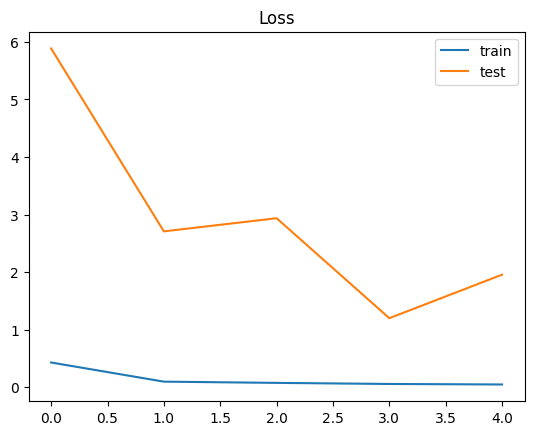

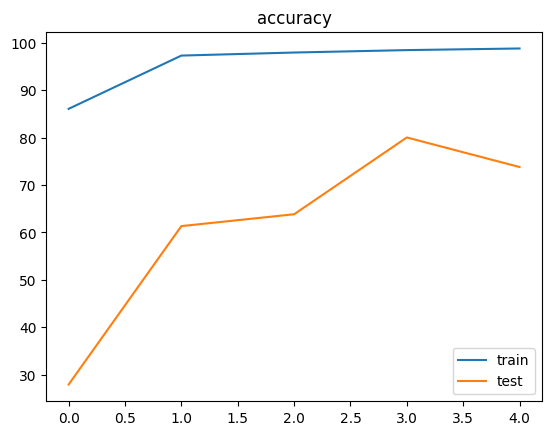

In [ ]:

import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random


import torchaudio.functional as Fa
import torchaudio.transforms as Ta


device = "cuda" if torch.cuda.is_available() else "cpu"


n_fft = 1024
win_length = None
hop_length = 128
spectrogram = Ta.Spectrogram(
  n_fft=n_fft,
  win_length=win_length,
  hop_length=hop_length,
  center=True,
  pad_mode="reflect",
  power=2.0
  ).to(device)

BATCH_SIZE = 256
EPOCHS = 5
LR = 1e-3

feature_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((200,200)),
    T.ToTensor()
])

label_transform = T.Compose([
    T.ToTensor()
])


def load_wav(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return audio

def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)



class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None, train=True, train_size=0.80):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))

        total_len = len(self.file_list)

        if train:
            self.file_list, self.label_list = self.file_list[:int(0.80 * total_len)], self.label_list[:int(0.80 * total_len)]
        else:
            self.file_list, self.label_list = self.file_list[int(0.80 * total_len):], self.label_list[int(0.80 * total_len):]

    def __getitem__(self, idx):
        try:
            spec = wav2melSpec(self.file_list[idx])
            #wav = load_wav(self.file_list[idx])
            #spec = spectrogram(wav)
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
        except:
            spec = wav2melSpec(self.file_list[0])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]

    def __len__(self):
        return len(self.file_list)

train_ds = AudioDataset('/content/AudioMNIST/data', feature_transform=feature_transform, label_transform=T.ToTensor(), train=True)

test_ds = AudioDataset('/content/AudioMNIST/data', feature_transform=feature_transform, label_transform=T.ToTensor(), train=False)

print(len(train_ds), len(test_ds))
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

trainimages, trainlabels, traintext = next(iter(train_dataloader))


class AudioClassifier(nn.Module):
    def __init__(self, num_feature_maps, layers):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//2),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//4),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_feature_maps//4, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )

        self.classifier = nn.ModuleList(
            [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        )

    def forward(self, x):
        a = self.conv_layer(x)
        for layer in self.classifier:
            a = layer(a)
        return a # as logits

num_feature_maps = 256
layers = [484, 128, 64, 32, 10]

clf = AudioClassifier(num_feature_maps, layers).to(device)

optim = torch.optim.Adam(lr=LR, params=clf.parameters(), betas=(0.5, 0.99))
loss_fn = nn.CrossEntropyLoss()

def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model, dataloader, optim, loss_fn, accuracy_fn):
    train_loss = 0.0
    train_acc = 0.0

    model.train()
    for batch, (X,y,txt) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)



        y_logits = model(X).to(device)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

        acc = accuracy_fn(y_preds, y)
        loss = loss_fn(y_logits, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
        train_acc += acc

        if batch % 50 == 0:
            sample = random.randint(0, BATCH_SIZE-2)
            print(f"\tBatch {batch}: Train loss: {loss:.5f} | Train accuracy : {acc:.2f}%")
            print("----------------------------------------")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss , train_acc


def eval_step(model, dataloader, optim, loss_fn, accuracy_fn):
    test_loss = 0.0
    test_acc = 0.0

    model.eval()
    with torch.inference_mode():
        for batch, (X,y,txt) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_logits = model(X).to(device)
            y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

            acc = accuracy_fn(y_preds, y)
            loss = loss_fn(y_logits, y)

            test_loss += loss.item()
            test_acc += acc

            if batch % 50 == 0:
                sample = random.randint(0, BATCH_SIZE-2)
                print(f"\tBatch {batch}: Test loss: {loss:.5f} | Test accuracy : {acc:.2f}%")
                print("----------------------------------------")

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc
lst_tr_acc = []
lst_te_acc = []
lst_tr_loss = []
lst_te_loss = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    train_loss , train_acc = train_step(clf, train_dataloader, optim, loss_fn, accuracy)
    test_loss, test_acc = eval_step(clf, test_dataloader, optim, loss_fn, accuracy)
    lst_tr_acc.append(train_acc)
    lst_te_acc.append(test_acc)
    lst_tr_loss.append(train_loss)
    lst_te_loss.append(test_loss)



plt.figure()
plt.title('Loss')
plt.plot(range(len(lst_tr_loss)),lst_tr_loss)
plt.plot(range(len(lst_te_loss)),lst_te_loss)
plt.legend(['train' ,'test'])


plt.figure()
plt.title('accuracy')
plt.plot(range(len(lst_tr_acc)),lst_tr_acc)
plt.plot(range(len(lst_te_acc)),lst_te_acc)
plt.legend(['train' ,'test'])

plt.show()


## **Conclusion**

In this lab we did some experiments on Forward- Forward algorithm. Different methods of embedding like positional and one hot encoding were used on different networks based on 1-d CNN and 2-d CNN for Audio Mnist classification task In this lab. Also for comparison the ordinary 2-d Cnn based on Backpropagation were used as well. Based on my observation Forward Forward is highly dependent on:


1.   **Embedding method.** The method is highly dependent on the embedding approach. Specially if the dimesion get increased in input side (2-d like specrogram, 3-d like increasing the chanelles, ...), and because the network in intfrence stage only accepts the embedded inputs; Thus the embedding strategy could directly affect the test resutls. For example for high dimentional input we can not simply use one hot encoding; as for 2-d input we used positional embedding.
2.   **Choosing the threshold.** $\theta$ as a hyperparameter is highly sensitive to prior knowledge and in optimization process directly could affet the local weights in each layer.
3. **Loss function.** As in the original paper stated, different losses can be employed in this setting.
4. **Appropriate Convergence rate.**
  Based on the analysis the that was provided in the first section of the report, the convergence of each layer may not be achived compared to the full parameter space provided by Backprop algorithm. This reasons may explain the not converging behaviour of the Networks on Audio data.

